# Project for Algorithms in Bioinformatics
## ATAC-seq network
ATAC-seq measures the chromatin accesibility, giving information about where the chromatin is open for transcription factors to bind and regulate the transcription of genes. Through a process called footprinting  we can get the sequence where the transcription factor binds. This sequence can then be matched to motifs to predict which transcription factor that binds to the open region. The footprinting and motif matching can be done using the regulatory genomics toolbox. The open region can also be annotated with close genes to predict which gene that is regulated. To annotate a region with nearest gene the R-package CHIPseeker can be used.

The motif matching and annotation to genes are done outside of this project. Here, I start with two files: 1. peaks with matched motif and 2. peaks with nearest gene. Peaks refers to an open chromatin region. These files are put together to a network.

In [2]:
import pandas as pd
import numpy as np

#read data
motif = pd.read_csv('project_data/Activation_mpbs.bed',sep='\t', header=None).iloc[:,:5]
motif.columns = ['seqnames','start','end','motif','score']
target = pd.read_csv('project_data/Activation_nearest_gene.bed',sep='\t').loc[:,['seqnames','start','end','annotation','geneId']]

# only use promoter regions
target_promoters = target[target.annotation.str.contains('Promoter')]

# correct for that the start of peak for motif and gene differs with one base.
target_promoters.loc[:,'start'] = target_promoters.loc[:,'start']-1

# remove not peaks with no annotation
target_promoters = target_promoters.dropna()

# make network by combining motif and target gene on peak.
network = pd.merge(motif,target_promoters, how='inner',on=['seqnames','start','end'])
network.loc[:,'motif'] = network['motif'].str.split('.').str[2] # remove motifID from name
network.loc[:,'motif'] = network['motif'].str.split('::').str[0] # if several annotated TFs only keep first
network = network.loc[:,['motif','geneId']]
network.columns = ['TF', 'target']
network = network.drop_duplicates()
network.to_csv('ATAC_prior.csv',sep='\t', index=False)

print('Prior: edges=',len(network),'tfs=',len(np.unique(network.TF)),'targets=',len(np.unique(network.target)))
network.head()

Prior: edges= 58857 tfs= 550 targets= 2175


,TF,target
0,Klf1,DDX11L1
1,KLF5,DDX11L1
2,NRF1,DDX11L1
3,ZIC4,LINC01128
5,ZIC3,LINC01128


## Apply network inference method on RNA-seq data
I input normalised expression data. The method also need a list of potential transcription factors, which I downloaded from http://humantfs.ccbr.utoronto.ca/.

### Read data
I format the data so that all possible TFs are present in the expression data. Also all TFs and targets in the prior should be present in the expression data.

In [3]:
exp = pd.read_csv('project_data/exp_normalized.csv', sep='\t', index_col='Unnamed: 0')
tfs = pd.read_csv('/home/bioinf/Documents/comhub/data/human_transcription_factors.txt', header=None)
prior = pd.read_csv('ATAC_prior.csv',sep='\t')
tfs = [tf for tf in np.array(tfs).flatten() if tf in exp.columns]
prior = prior[prior.isin(exp.columns)].dropna()
prior = prior[prior.TF.isin(np.array(tfs).flatten())]
print('Prior: edges=',len(prior),'tfs=',len(np.unique(prior.TF)),'targets=',len(np.unique(prior.target)))

Prior: edges= 35513 tfs= 410 targets= 1780


### Network inference
I use a simple network inference method that ranks edges based on the absolute value of the Pearson correlation coefficient. I will do the network inference both without and with a prior, and compare the resulting networks. The prior is considered by multiplying the correlation value for all edges present in the prior with a weight, increasing the importance of those edges. I am also interested in how diffent weights on the prior edges affects the results.

In [33]:
def pcc(exp, tfs, prior=None, prior_weight=1.5, network_cutoff=100000):
    """
    Absolute value of the Pearson correlation coefficient (PCC)
    Regulator-target interactions are ranked based on the absolute value of the PCC.
    """
    tfs = np.array(tfs).flatten()
    tfs = [tf for tf in tfs if tf in exp.columns]
    tfs_index = np.where(np.isin(exp.columns,tfs) == True)[0]

    print('calculating pcc')
    corrmat = np.corrcoef(np.array(exp.T))
    corrmat = np.abs(corrmat[tfs_index,:])
    corrmat = pd.DataFrame(corrmat, index=tfs, columns=exp.columns)
    
    #prior
    if prior is not None: 
        prior.loc[:,'value'] = np.ones(len(prior))
        prior_mat = prior.pivot(index='TF', columns='target', values='value')
        prior_mat = prior_mat*prior_weight
        prior_mat = prior_mat.loc[corrmat.index,corrmat.columns].fillna(1)
        corrmat = prior_mat*corrmat

    print('making network')
    net = corrmat.reset_index().melt(id_vars=['index'])
    net.columns = ['TF', 'target', 'confidence']
    net = net[net.TF != net.target]
    net_sort = net.sort_values(by='confidence', ascending=False).iloc[:network_cutoff, :]

    return net_sort

In [31]:
net = pcc(exp, tfs, network_cutoff=10000)
net.to_csv('pcc_network.csv', header=None, index=False, sep='\t')

calculating pcc
making network


In [35]:
net_prior12 = pcc(exp, tfs, prior, prior_weight=1.2, network_cutoff=10000)
net_prior12.to_csv('pcc_network_prior_1.2.csv', header=None, index=False, sep='\t')
net_prior15 = pcc(exp, tfs, prior, prior_weight=1.5, network_cutoff=10000)
net_prior15.to_csv('pcc_network_prior_1.5.csv', header=None, index=False, sep='\t')
net_prior2 = pcc(exp, tfs, prior, prior_weight=2, network_cutoff=10000)
net_prior2.to_csv('pcc_network_prior_2.csv', header=None, index=False, sep='\t')

calculating pcc
making network
calculating pcc
making network
calculating pcc
making network


## Network analysis

I start by calculating the outdegree distribution of both networks.

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
net_df = pd.read_csv('pcc_network.csv', header=None, sep='\t')
net = nx.from_pandas_edgelist(net_df, source = 0, target = 1)

In [38]:
net_prior12_df = pd.read_csv('pcc_network_prior_1.2.csv', header=None, sep='\t')
net_prior12 = nx.from_pandas_edgelist(net_prior12_df, source = 0, target = 1)
net_prior15_df = pd.read_csv('pcc_network_prior_1.5.csv', header=None, sep='\t')
net_prior15 = nx.from_pandas_edgelist(net_prior15_df, source = 0, target = 1)
net_prior2_df = pd.read_csv('pcc_network_prior_2.csv', header=None, sep='\t')
net_prior2 = nx.from_pandas_edgelist(net_prior2_df, source = 0, target = 1)

### Degree distribution

In [46]:
def plot_hist(degree_list, degree_list_prior12, degree_list_prior15, degree_list_prior2):
    color_pallet = "bright"
    plt.style.use('seaborn-ticks')
    sns.set_color_codes(color_pallet)
    fig, ax = plt.subplots(ncols=2, nrows=2, facecolor='w', edgecolor='k', figsize=(15, 10), dpi=75)
    plt.rc('font', size=28)
    plt.rc('ytick', labelsize=24)
    plt.rc('xtick', labelsize=24)

    ax[0,0].hist(degree_list, bins=100)
    ax[0,1].hist(degree_list_prior12, bins=100)
    ax[1,0].hist(degree_list_prior15, bins=100)
    ax[1,1].hist(degree_list_prior2, bins=100)

    ax[0,0].set_xlabel('degree')
    ax[0,1].set_xlabel('degree')
    ax[1,0].set_xlabel('degree')
    ax[1,1].set_xlabel('degree')
    ax[0,0].set_title('w/o prior')
    ax[0,1].set_title('prior 1.2')
    ax[1,0].set_title('prior 1.5')
    ax[1,1].set_title('prior 2')

    plt.subplots_adjust(hspace=0.5)

    sns.despine()
    plt.show()
    return fig

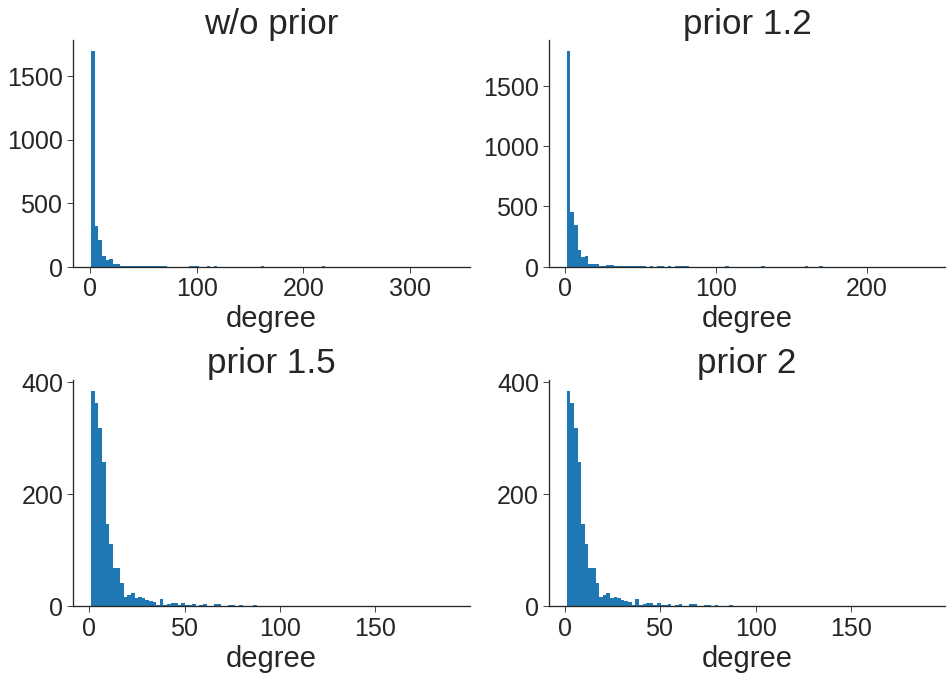

In [49]:
degree_list = [d for n, d in net.degree]
degree_list_prior12 = [d for n, d in net_prior12.degree]
degree_list_prior15 = [d for n, d in net_prior15.degree]
degree_list_prior2 = [d for n, d in net_prior2.degree]

fig = plot_hist(degree_list, degree_list_prior12, degree_list_prior15, degree_list_prior2)

### Identify hubs
Here, I consider TFs standing for 10% of the interactions in the networks to be hubs.

In [40]:
def get_hubs(net):
    TF_outdegrees = pd.DataFrame(net.degree).sort_values(by=1, ascending=False)
    TF_outdegrees.index = TF_outdegrees[0]
    TF_outdegrees = TF_outdegrees.drop(0,1)
    hubs = TF_outdegrees[TF_outdegrees[1].cumsum() < TF_outdegrees[1].sum()*0.1]
    return hubs

In [41]:
hubs = get_hubs(net)
hubs_prior12 = get_hubs(net_prior12)
hubs_prior15 = get_hubs(net_prior15)
hubs_prior2 = get_hubs(net_prior2)

### Clustering coefficient
How densely connected is the network around each node.

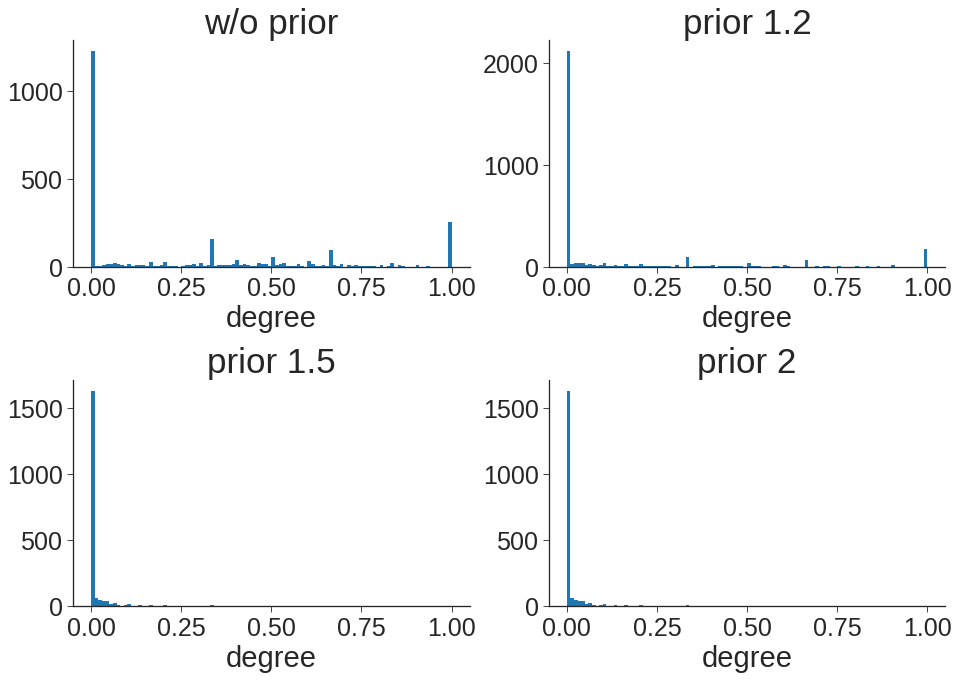

In [58]:
clustering_coeff =  [value for item, value in nx.clustering(net).items()]
clustering_coeff12 =  [value for item, value in nx.clustering(net_prior12).items()]
clustering_coeff15 =  [value for item, value in nx.clustering(net_prior15).items()]
clustering_coeff2 =  [value for item, value in nx.clustering(net_prior2).items()]

fig = plot_hist(clustering_coeff, clustering_coeff12, clustering_coeff15, clustering_coeff2)